# Artificial Neural Network Code with MNIST

This is jupyter notebook for basic ANN and dense layer using `Tensorflow`. 
<br> Dataset is MNIST dataset.

In [1]:
# Import modules

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Q\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import MNIST data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Parameters

In [3]:
# Parameters 
img_size = 28
data_size = 28 * 28

# labels: 0 - 9
num_label = 10

# Parameters for optimizer
num_epoch = 10

learning_rate = 5e-4
batch_size = 512

validation_ratio = 0.1
gpu_fraction = 0.2

# Fully Connected [kernel size, kernel size, # input, # output]
first_fc  = [data_size, 256]
second_fc = [256, 1024]
third_fc  = [1024, num_label]

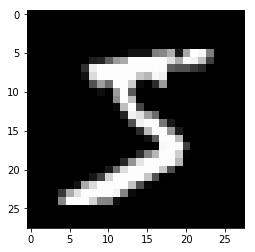

In [4]:
# Plotting example image
img = mnist.train.images[0]
img_resize = img.reshape((img_size, img_size))
plt.imshow(img_resize, cmap = 'gray')
plt.show()

## Functions

In [5]:
# Initialize weights and bias 
def weight_variable(name, shape):
    return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## CNN Network

In [6]:
# Reset graph
tf.reset_default_graph()

# Input 
x_input  = tf.placeholder(tf.float32, shape = [None, data_size])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

# Keep Prob
keep_prob = tf.placeholder("float")

# Densely connect layer variables 
w_fc1 = weight_variable('W_fc1', first_fc)
b_fc1 = bias_variable('b_fc1', first_fc[1])

w_fc2 = weight_variable('W_fc2', second_fc)
b_fc2 = bias_variable('b_fc2', second_fc[1])

w_fc3 = weight_variable('W_fc3', third_fc)
b_fc3 = bias_variable('b_fc3', third_fc[1])

# Network
h_fc1 = tf.nn.relu(tf.matmul(x_input, w_fc1)+b_fc1)
h_fc2 = tf.nn.relu(tf.matmul(h_fc1, w_fc2)+b_fc2)

# Dropout
h_fc1_drop = tf.nn.dropout(h_fc2, keep_prob)

# Output
output = tf.matmul(h_fc1_drop, w_fc3)+b_fc3

## Set Loss and Optimizer

In [7]:
# Training 
Loss = tf.reduce_mean(tf.square(output - y_target))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Loss)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Making Dataset

In [8]:
# Dataset for train, test, validation

test_len = mnist.test.images.shape[0]
validation_len = int(test_len * validation_ratio)

train_x = mnist.train.images
test_x = mnist.test.images[validation_len : test_len, :]
validation_x = mnist.test.images[ : validation_len, :]

train_y = mnist.train.labels
test_y = mnist.test.labels[validation_len : test_len]
validation_y = mnist.test.labels[ : validation_len]

print("Training set: " + str(train_x.shape))
print("Testing set: " + str(test_x.shape))
print("Validation set: " + str(validation_x.shape))

Training set: (60000, 784)
Testing set: (9000, 784)
Validation set: (1000, 784)


## Create Session

In [9]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Training

In [10]:
# Training
data = np.insert(train_x, data_size, train_y, axis = 1)
len_data = data.shape[0]

for i in range(num_epoch):
    # Shuffle the data 
    np.random.shuffle(data)
    
    # Split data to input can label
    data_x = data[:, : data_size]
    data_y = data[:, data_size]
    
    # Make label data as one-hot
    data_y_onehot = np.zeros([data_y.shape[0], num_label])
    for j in range(data_y.shape[0]):
        data_y_onehot[j, int(data_y[j])] = 1
    
    data_y_onehot_val = np.zeros([validation_y.shape[0], num_label])
    for j in range(validation_y.shape[0]):
        data_y_onehot_val[j, int(validation_y[j])] = 1
    
    # Making mini-batch
    batch_count = 1
    for j in range(0, len_data, batch_size):
        if j + batch_size < len_data:
            data_x_in = data_x[j : j + batch_size, :]
            data_y_in = data_y_onehot[j : j + batch_size, :]
        else:
            data_x_in = data_x[j : len_data, :]
            data_y_in = data_y_onehot[j : len_data, :]

        # Run Optimizer!
        optimizer.run(feed_dict = {x_input: data_x_in, y_target: data_y_in, keep_prob: 0.5})
        
        
        loss, acc = sess.run([Loss, accuracy], feed_dict = {x_input: data_x_in, y_target: data_y_in, keep_prob: 1})
        val_loss, val_acc = sess.run([Loss, accuracy], feed_dict = {x_input: validation_x, y_target: data_y_onehot_val, keep_prob: 1})
        
        print("Epoch: " + str(i+1) + ' / ' + "Batch: " + str(j) + '/' + str(len_data) + ' / ' + "Loss: " + str(loss) + ' / ' + \
              "Training Accuracy: " + str(acc) + ' / ' + "Validation Accuracy: " + str(val_acc))



Epoch: 1 / Batch: 0/60000 / Loss: 0.12492554 / Training Accuracy: 0.1796875 / Validation Accuracy: 0.168
Epoch: 1 / Batch: 512/60000 / Loss: 0.100588605 / Training Accuracy: 0.17773438 / Validation Accuracy: 0.195
Epoch: 1 / Batch: 1024/60000 / Loss: 0.10555182 / Training Accuracy: 0.265625 / Validation Accuracy: 0.233
Epoch: 1 / Batch: 1536/60000 / Loss: 0.101049915 / Training Accuracy: 0.26171875 / Validation Accuracy: 0.298
Epoch: 1 / Batch: 2048/60000 / Loss: 0.085446544 / Training Accuracy: 0.37890625 / Validation Accuracy: 0.378
Epoch: 1 / Batch: 2560/60000 / Loss: 0.07814864 / Training Accuracy: 0.4765625 / Validation Accuracy: 0.469
Epoch: 1 / Batch: 3072/60000 / Loss: 0.07087539 / Training Accuracy: 0.52734375 / Validation Accuracy: 0.514
Epoch: 1 / Batch: 3584/60000 / Loss: 0.06934183 / Training Accuracy: 0.5332031 / Validation Accuracy: 0.532
Epoch: 1 / Batch: 4096/60000 / Loss: 0.06968917 / Training Accuracy: 0.56640625 / Validation Accuracy: 0.549
Epoch: 1 / Batch: 4608/60

Epoch: 1 / Batch: 40448/60000 / Loss: 0.024045656 / Training Accuracy: 0.9140625 / Validation Accuracy: 0.899
Epoch: 1 / Batch: 40960/60000 / Loss: 0.022762176 / Training Accuracy: 0.9121094 / Validation Accuracy: 0.899
Epoch: 1 / Batch: 41472/60000 / Loss: 0.022427555 / Training Accuracy: 0.92578125 / Validation Accuracy: 0.9
Epoch: 1 / Batch: 41984/60000 / Loss: 0.024375767 / Training Accuracy: 0.9042969 / Validation Accuracy: 0.903
Epoch: 1 / Batch: 42496/60000 / Loss: 0.02063681 / Training Accuracy: 0.9238281 / Validation Accuracy: 0.904
Epoch: 1 / Batch: 43008/60000 / Loss: 0.022096936 / Training Accuracy: 0.93359375 / Validation Accuracy: 0.906
Epoch: 1 / Batch: 43520/60000 / Loss: 0.0232874 / Training Accuracy: 0.9082031 / Validation Accuracy: 0.904
Epoch: 1 / Batch: 44032/60000 / Loss: 0.02133976 / Training Accuracy: 0.921875 / Validation Accuracy: 0.905
Epoch: 1 / Batch: 44544/60000 / Loss: 0.020678539 / Training Accuracy: 0.9238281 / Validation Accuracy: 0.905
Epoch: 1 / Batc

Epoch: 2 / Batch: 20480/60000 / Loss: 0.017000671 / Training Accuracy: 0.9453125 / Validation Accuracy: 0.936
Epoch: 2 / Batch: 20992/60000 / Loss: 0.016323704 / Training Accuracy: 0.94140625 / Validation Accuracy: 0.936
Epoch: 2 / Batch: 21504/60000 / Loss: 0.016122181 / Training Accuracy: 0.94921875 / Validation Accuracy: 0.937
Epoch: 2 / Batch: 22016/60000 / Loss: 0.018275252 / Training Accuracy: 0.92578125 / Validation Accuracy: 0.936
Epoch: 2 / Batch: 22528/60000 / Loss: 0.016173337 / Training Accuracy: 0.9316406 / Validation Accuracy: 0.939
Epoch: 2 / Batch: 23040/60000 / Loss: 0.014755783 / Training Accuracy: 0.94921875 / Validation Accuracy: 0.936
Epoch: 2 / Batch: 23552/60000 / Loss: 0.015463099 / Training Accuracy: 0.9628906 / Validation Accuracy: 0.935
Epoch: 2 / Batch: 24064/60000 / Loss: 0.015868643 / Training Accuracy: 0.9433594 / Validation Accuracy: 0.935
Epoch: 2 / Batch: 24576/60000 / Loss: 0.015751733 / Training Accuracy: 0.94921875 / Validation Accuracy: 0.935
Epoch

Epoch: 3 / Batch: 0/60000 / Loss: 0.014272382 / Training Accuracy: 0.9550781 / Validation Accuracy: 0.949
Epoch: 3 / Batch: 512/60000 / Loss: 0.012508172 / Training Accuracy: 0.9589844 / Validation Accuracy: 0.951
Epoch: 3 / Batch: 1024/60000 / Loss: 0.011598603 / Training Accuracy: 0.96875 / Validation Accuracy: 0.953
Epoch: 3 / Batch: 1536/60000 / Loss: 0.012213133 / Training Accuracy: 0.95703125 / Validation Accuracy: 0.953
Epoch: 3 / Batch: 2048/60000 / Loss: 0.011002369 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.953
Epoch: 3 / Batch: 2560/60000 / Loss: 0.013546069 / Training Accuracy: 0.9589844 / Validation Accuracy: 0.952
Epoch: 3 / Batch: 3072/60000 / Loss: 0.014300113 / Training Accuracy: 0.94140625 / Validation Accuracy: 0.952
Epoch: 3 / Batch: 3584/60000 / Loss: 0.010741546 / Training Accuracy: 0.9707031 / Validation Accuracy: 0.952
Epoch: 3 / Batch: 4096/60000 / Loss: 0.012105563 / Training Accuracy: 0.9609375 / Validation Accuracy: 0.953
Epoch: 3 / Batch: 4608/

Epoch: 3 / Batch: 42496/60000 / Loss: 0.012253843 / Training Accuracy: 0.9550781 / Validation Accuracy: 0.958
Epoch: 3 / Batch: 43008/60000 / Loss: 0.011161426 / Training Accuracy: 0.9609375 / Validation Accuracy: 0.959
Epoch: 3 / Batch: 43520/60000 / Loss: 0.011802243 / Training Accuracy: 0.9609375 / Validation Accuracy: 0.959
Epoch: 3 / Batch: 44032/60000 / Loss: 0.010287412 / Training Accuracy: 0.9746094 / Validation Accuracy: 0.959
Epoch: 3 / Batch: 44544/60000 / Loss: 0.011569223 / Training Accuracy: 0.9589844 / Validation Accuracy: 0.959
Epoch: 3 / Batch: 45056/60000 / Loss: 0.011559039 / Training Accuracy: 0.9550781 / Validation Accuracy: 0.958
Epoch: 3 / Batch: 45568/60000 / Loss: 0.009928063 / Training Accuracy: 0.97265625 / Validation Accuracy: 0.958
Epoch: 3 / Batch: 46080/60000 / Loss: 0.009713894 / Training Accuracy: 0.9707031 / Validation Accuracy: 0.959
Epoch: 3 / Batch: 46592/60000 / Loss: 0.010383071 / Training Accuracy: 0.96875 / Validation Accuracy: 0.96
Epoch: 3 / B

Epoch: 4 / Batch: 20480/60000 / Loss: 0.010162425 / Training Accuracy: 0.9589844 / Validation Accuracy: 0.964
Epoch: 4 / Batch: 20992/60000 / Loss: 0.010700616 / Training Accuracy: 0.96875 / Validation Accuracy: 0.965
Epoch: 4 / Batch: 21504/60000 / Loss: 0.010996477 / Training Accuracy: 0.95703125 / Validation Accuracy: 0.964
Epoch: 4 / Batch: 22016/60000 / Loss: 0.009547106 / Training Accuracy: 0.9707031 / Validation Accuracy: 0.962
Epoch: 4 / Batch: 22528/60000 / Loss: 0.010106383 / Training Accuracy: 0.9609375 / Validation Accuracy: 0.964
Epoch: 4 / Batch: 23040/60000 / Loss: 0.009707788 / Training Accuracy: 0.9609375 / Validation Accuracy: 0.965
Epoch: 4 / Batch: 23552/60000 / Loss: 0.009192985 / Training Accuracy: 0.96484375 / Validation Accuracy: 0.963
Epoch: 4 / Batch: 24064/60000 / Loss: 0.00902458 / Training Accuracy: 0.96875 / Validation Accuracy: 0.963
Epoch: 4 / Batch: 24576/60000 / Loss: 0.009683147 / Training Accuracy: 0.9667969 / Validation Accuracy: 0.963
Epoch: 4 / Ba

Epoch: 5 / Batch: 0/60000 / Loss: 0.007960042 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.963
Epoch: 5 / Batch: 512/60000 / Loss: 0.00976177 / Training Accuracy: 0.9667969 / Validation Accuracy: 0.963
Epoch: 5 / Batch: 1024/60000 / Loss: 0.008834236 / Training Accuracy: 0.97265625 / Validation Accuracy: 0.962
Epoch: 5 / Batch: 1536/60000 / Loss: 0.007658287 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.963
Epoch: 5 / Batch: 2048/60000 / Loss: 0.0072119385 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.963
Epoch: 5 / Batch: 2560/60000 / Loss: 0.009065205 / Training Accuracy: 0.97265625 / Validation Accuracy: 0.962
Epoch: 5 / Batch: 3072/60000 / Loss: 0.00801081 / Training Accuracy: 0.9707031 / Validation Accuracy: 0.964
Epoch: 5 / Batch: 3584/60000 / Loss: 0.007020534 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.964
Epoch: 5 / Batch: 4096/60000 / Loss: 0.008859466 / Training Accuracy: 0.96875 / Validation Accuracy: 0.964
Epoch: 5 / Batch: 4608/

Epoch: 5 / Batch: 41984/60000 / Loss: 0.0070119193 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.967
Epoch: 5 / Batch: 42496/60000 / Loss: 0.007850096 / Training Accuracy: 0.9746094 / Validation Accuracy: 0.967
Epoch: 5 / Batch: 43008/60000 / Loss: 0.009014609 / Training Accuracy: 0.9628906 / Validation Accuracy: 0.969
Epoch: 5 / Batch: 43520/60000 / Loss: 0.007206832 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.97
Epoch: 5 / Batch: 44032/60000 / Loss: 0.006836321 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.969
Epoch: 5 / Batch: 44544/60000 / Loss: 0.0071439994 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.968
Epoch: 5 / Batch: 45056/60000 / Loss: 0.0068862797 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.968
Epoch: 5 / Batch: 45568/60000 / Loss: 0.009348834 / Training Accuracy: 0.9589844 / Validation Accuracy: 0.967
Epoch: 5 / Batch: 46080/60000 / Loss: 0.007031262 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.966
Epoch: 

Epoch: 6 / Batch: 23040/60000 / Loss: 0.0070332317 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.967
Epoch: 6 / Batch: 23552/60000 / Loss: 0.0062276167 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.968
Epoch: 6 / Batch: 24064/60000 / Loss: 0.006487568 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.969
Epoch: 6 / Batch: 24576/60000 / Loss: 0.0075352592 / Training Accuracy: 0.96875 / Validation Accuracy: 0.968
Epoch: 6 / Batch: 25088/60000 / Loss: 0.006449727 / Training Accuracy: 0.9746094 / Validation Accuracy: 0.968
Epoch: 6 / Batch: 25600/60000 / Loss: 0.0059869653 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.968
Epoch: 6 / Batch: 26112/60000 / Loss: 0.007619261 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.969
Epoch: 6 / Batch: 26624/60000 / Loss: 0.007018124 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.97
Epoch: 6 / Batch: 27136/60000 / Loss: 0.0058768345 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.97
Epoch:

Epoch: 7 / Batch: 10752/60000 / Loss: 0.006175979 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.968
Epoch: 7 / Batch: 11264/60000 / Loss: 0.0062125125 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.968
Epoch: 7 / Batch: 11776/60000 / Loss: 0.006391458 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.967
Epoch: 7 / Batch: 12288/60000 / Loss: 0.0067462013 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.967
Epoch: 7 / Batch: 12800/60000 / Loss: 0.006324184 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.967
Epoch: 7 / Batch: 13312/60000 / Loss: 0.005829458 / Training Accuracy: 0.984375 / Validation Accuracy: 0.967
Epoch: 7 / Batch: 13824/60000 / Loss: 0.0054267813 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.968
Epoch: 7 / Batch: 14336/60000 / Loss: 0.0065250574 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.968
Epoch: 7 / Batch: 14848/60000 / Loss: 0.007119729 / Training Accuracy: 0.97265625 / Validation Accuracy: 0.968
Epoc

Epoch: 7 / Batch: 53248/60000 / Loss: 0.006389259 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.969
Epoch: 7 / Batch: 53760/60000 / Loss: 0.006194503 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.969
Epoch: 7 / Batch: 54272/60000 / Loss: 0.006209478 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.969
Epoch: 7 / Batch: 54784/60000 / Loss: 0.0061520212 / Training Accuracy: 0.9707031 / Validation Accuracy: 0.969
Epoch: 7 / Batch: 55296/60000 / Loss: 0.005462267 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.968
Epoch: 7 / Batch: 55808/60000 / Loss: 0.0049452386 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.968
Epoch: 7 / Batch: 56320/60000 / Loss: 0.005747877 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.968
Epoch: 7 / Batch: 56832/60000 / Loss: 0.005558121 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.966
Epoch: 7 / Batch: 57344/60000 / Loss: 0.0069835978 / Training Accuracy: 0.97265625 / Validation Accuracy: 0.964
Epoc

Epoch: 8 / Batch: 33280/60000 / Loss: 0.0041658054 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.97
Epoch: 8 / Batch: 33792/60000 / Loss: 0.005850632 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.97
Epoch: 8 / Batch: 34304/60000 / Loss: 0.005747667 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.97
Epoch: 8 / Batch: 34816/60000 / Loss: 0.005845344 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.969
Epoch: 8 / Batch: 35328/60000 / Loss: 0.00481462 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.969
Epoch: 8 / Batch: 35840/60000 / Loss: 0.0049943095 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.969
Epoch: 8 / Batch: 36352/60000 / Loss: 0.0058329995 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.969
Epoch: 8 / Batch: 36864/60000 / Loss: 0.0051677437 / Training Accuracy: 0.984375 / Validation Accuracy: 0.969
Epoch: 8 / Batch: 37376/60000 / Loss: 0.0049638674 / Training Accuracy: 0.984375 / Validation Accuracy: 0.97
Epoch: 8 / B

Epoch: 9 / Batch: 11264/60000 / Loss: 0.0044562756 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.972
Epoch: 9 / Batch: 11776/60000 / Loss: 0.0038657612 / Training Accuracy: 0.9941406 / Validation Accuracy: 0.97
Epoch: 9 / Batch: 12288/60000 / Loss: 0.0059192716 / Training Accuracy: 0.97265625 / Validation Accuracy: 0.97
Epoch: 9 / Batch: 12800/60000 / Loss: 0.0044151847 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.971
Epoch: 9 / Batch: 13312/60000 / Loss: 0.004706443 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.971
Epoch: 9 / Batch: 13824/60000 / Loss: 0.004914127 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.97
Epoch: 9 / Batch: 14336/60000 / Loss: 0.0050524473 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.969
Epoch: 9 / Batch: 14848/60000 / Loss: 0.004436622 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.971
Epoch: 9 / Batch: 15360/60000 / Loss: 0.005336008 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.971
Epoc

Epoch: 9 / Batch: 51712/60000 / Loss: 0.0061620395 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.974
Epoch: 9 / Batch: 52224/60000 / Loss: 0.004890645 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.974
Epoch: 9 / Batch: 52736/60000 / Loss: 0.0048738373 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.974
Epoch: 9 / Batch: 53248/60000 / Loss: 0.0043759416 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.973
Epoch: 9 / Batch: 53760/60000 / Loss: 0.0051681516 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.973
Epoch: 9 / Batch: 54272/60000 / Loss: 0.005713977 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.973
Epoch: 9 / Batch: 54784/60000 / Loss: 0.0047902004 / Training Accuracy: 0.984375 / Validation Accuracy: 0.97
Epoch: 9 / Batch: 55296/60000 / Loss: 0.004609608 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.972
Epoch: 9 / Batch: 55808/60000 / Loss: 0.005526763 / Training Accuracy: 0.984375 / Validation Accuracy: 0.973
Epoch: 

Epoch: 10 / Batch: 29184/60000 / Loss: 0.0040702173 / Training Accuracy: 0.99609375 / Validation Accuracy: 0.972
Epoch: 10 / Batch: 29696/60000 / Loss: 0.004941004 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.973
Epoch: 10 / Batch: 30208/60000 / Loss: 0.0044386676 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.973
Epoch: 10 / Batch: 30720/60000 / Loss: 0.0040496765 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.973
Epoch: 10 / Batch: 31232/60000 / Loss: 0.004887095 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.973
Epoch: 10 / Batch: 31744/60000 / Loss: 0.004623507 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.973
Epoch: 10 / Batch: 32256/60000 / Loss: 0.0044097966 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.973
Epoch: 10 / Batch: 32768/60000 / Loss: 0.0038930178 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.973
Epoch: 10 / Batch: 33280/60000 / Loss: 0.004204483 / Training Accuracy: 0.9921875 / Validation Accuracy: 

## Testing

In [11]:
# Testing
test_y_onehot = np.zeros([test_y.shape[0], num_label])
for i in range(test_y.shape[0]):
    test_y_onehot[i, int(test_y[i])] = 1

test_result = output.eval(feed_dict = {x_input: test_x, keep_prob: 1})

count_correct = 0
for i in range(test_result.shape[0]):
    prediction_y = np.argmax(test_result[i,:])
    
    if prediction_y == test_y[i]:
        count_correct += 1

test_acc = count_correct / test_result.shape[0]

print("Test Accuracy: " + str(test_acc))

Test Accuracy: 0.9764444444444444
